In [1]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img
from tensorflow.keras.utils import image_dataset_from_directory
from collections import Counter
import numpy as np
import os
import shutil
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

import kagglehub


path = kagglehub.dataset_download("rajumavinmar/finger-print-based-blood-group-dataset")

print("Path to dataset files:", path)



100%|██████████| 58.1M/58.1M [00:03<00:00, 16.7MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/rajumavinmar/finger-print-based-blood-group-dataset/versions/1


In [4]:

BATCH_SIZE = 32

In [5]:
data_dir = os.path.join(path, 'dataset_blood_group')


In [6]:
dataset = image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    image_size=(64, 64),
    batch_size=BATCH_SIZE,
    shuffle=True
)


Found 6000 files belonging to 8 classes.


In [7]:
class_names = dataset.class_names
print("Detected blood group class names:", class_names)


Detected blood group class names: ['A+', 'A-', 'AB+', 'AB-', 'B+', 'B-', 'O+', 'O-']


In [8]:
class_names = dataset.class_names
class_counts = Counter()

for images, labels in dataset.unbatch():
    class_counts[int(labels.numpy())] += 1

print("Class Distribution:")
for i, count in class_counts.items():
    print(f"{class_names[i]}: {count}")



Class Distribution:
O+: 852
B-: 741
B+: 652
AB+: 708
A-: 1009
O-: 712
A+: 565
AB-: 761


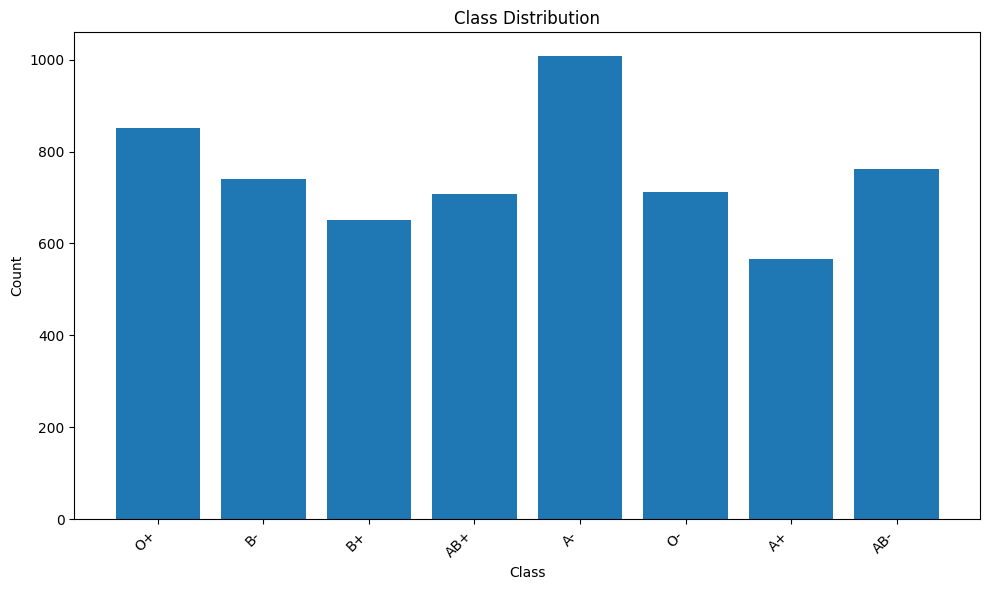

In [9]:
import matplotlib.pyplot as plt

def plot_class_distribution(class_names, class_counts):
    """Plots the distribution of classes in the dataset."""

    classes = [class_names[i] for i in class_counts.keys()]
    counts = [class_counts[i] for i in class_counts.keys()]

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.title('Class Distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_class_distribution(class_names, class_counts)


In [10]:
max_count = max(class_counts.values())
print("Max count:", max_count)


Max count: 1009


In [11]:

def oversample_class(class_id, count, max_count):
    """Oversamples a specific class to balance the dataset.

    Args:
        class_id (int): The ID of the class to oversample.
        count (int): The current number of samples in the class.
        max_count (int): The desired number of samples in the class.

    Returns:
        tf.data.Dataset: An oversampled dataset for the specified class.
    """

    unbatched_dataset = dataset.unbatch()


    class_dataset = unbatched_dataset.filter(lambda img, lbl: tf.equal(lbl, class_id))


    repeat_factor = max_count // count + (max_count % count > 0)


    return class_dataset.repeat(repeat_factor).take(max_count)

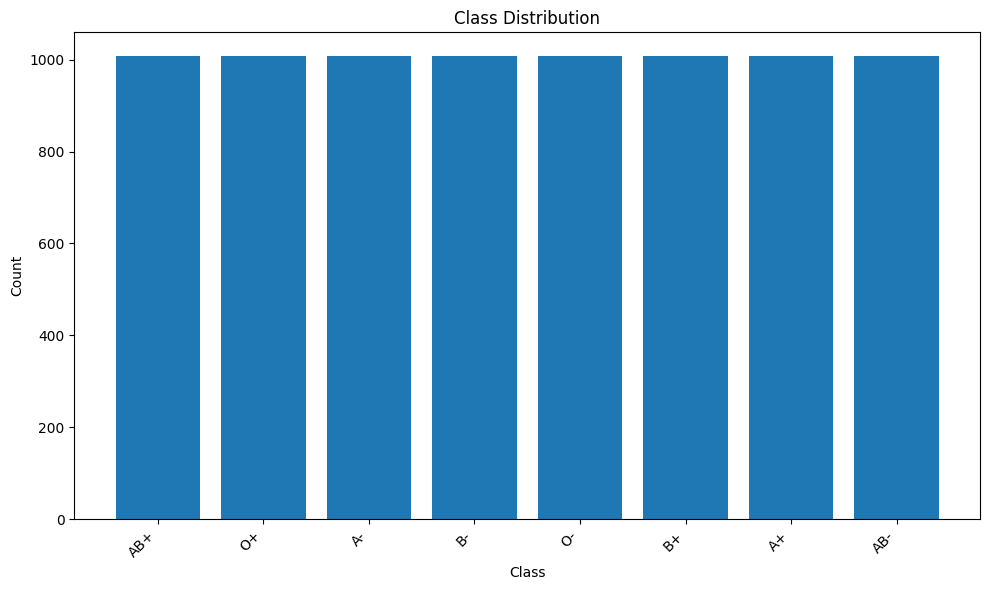

In [12]:
balanced_datasets = []
for class_id, count in class_counts.items():
    balanced_datasets.append(oversample_class(class_id, count, max_count))


balanced_dataset = tf.data.Dataset.sample_from_datasets(balanced_datasets)


balanced_class_counts = Counter([int(lbl.numpy()) for _, lbl in balanced_dataset])
plot_class_distribution(class_names, balanced_class_counts)


balanced_dataset = balanced_dataset.batch(BATCH_SIZE, drop_remainder=True)

In [13]:
for sample in balanced_dataset.take(10):
    print(sample[0].shape)

(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)
(32, 64, 64, 3)


In [14]:
balanced_dataset_unbatched = balanced_dataset.unbatch()
dataset_size = sum(1 for _ in balanced_dataset_unbatched)
print(f"Total number of samples in the dataset: {dataset_size}")

Total number of samples in the dataset: 8064


In [15]:

balanced_dataset_unbatched = balanced_dataset.unbatch()

train_ratio = 0.8
val_ratio = 0.1
dataset_size = sum(1 for _ in balanced_dataset_unbatched)

train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)


train_dataset = balanced_dataset_unbatched.take(train_size)
val_test_dataset = balanced_dataset_unbatched.skip(train_size)
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)

train_batch_count = sum(1 for _ in train_dataset)
val_batch_count = sum(1 for _ in val_dataset)
test_batch_count = sum(1 for _ in test_dataset)

print(f"Training dataset size: {train_batch_count * BATCH_SIZE}")
print(f"Validation dataset size: {val_batch_count * BATCH_SIZE}")
print(f"Testing dataset size: {test_batch_count * BATCH_SIZE}")

Training dataset size: 6432
Validation dataset size: 800
Testing dataset size: 800


In [16]:
def create_high_accuracy_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model
    high_acc_model = create_high_accuracy_model()

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)


early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

In [20]:

high_acc_model = create_high_accuracy_model()
history_high_acc = high_acc_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/50
    201/Unknown 19s 40ms/step - accuracy: 0.1296 - loss: 31.6601

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


201/201 ━━━━━━━━━━━━━━━━━━━━ 27s 81ms/step - accuracy: 0.1296 - loss: 31.5451 - val_accuracy: 0.2062 - val_loss: 2.0386 - learning_rate: 0.0010
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - accuracy: 0.2825 - loss: 1.8231 - val_accuracy: 0.5813 - val_loss: 1.4535 - learning_rate: 0.0010
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.5838 - loss: 1.1577 - val_accuracy: 0.6338 - val_loss: 1.3004 - learning_rate: 0.0010
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.6383 - loss: 0.9753 - val_accuracy: 0.7063 - val_loss: 1.1372 - learning_rate: 0.0010
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - accuracy: 0.7062 - loss: 0.8285 - val_accuracy: 0.7150 - val_loss: 1.1106 - learning_rate: 0.0010
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 20s 100ms/step - accuracy: 0.7297 - loss: 0.7489 - val_accuracy: 0.8050 - val_loss: 0.9654 - learning_rate: 0.0010
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 15s 73ms/step - accuracy: 0.7402 - loss: 0.6

In [21]:

high_acc_eval = high_acc_model.evaluate(val_dataset)

print(f"High Accuracy Model - Loss: {high_acc_eval[0]}, Accuracy: {high_acc_eval[1]}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.9484 - loss: 0.2792
High Accuracy Model - Loss: 0.2827645540237427, Accuracy: 0.9399999976158142


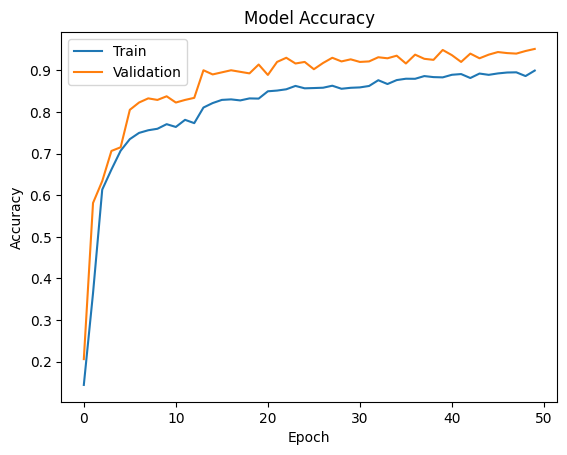

In [22]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
def plot_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


plot_accuracy(history_high_acc)

In [23]:
high_acc_model.save('model.h5')
print("Model saved as HDF5 format.")

Model saved as HDF5 format.


In [24]:
pip show pillow


Name: pillow
Version: 11.1.0
Summary: Python Imaging Library (Fork)
Home-page: https://python-pillow.github.io
Author: 
Author-email: "Jeffrey A. Clark" <aclark@aclark.net>
License: MIT-CMU
Location: /usr/local/lib/python3.11/dist-packages
Requires: 
Required-by: bokeh, diffusers, dopamine_rl, fastai, imageio, matplotlib, scikit-image, sentence-transformers, torchvision, wordcloud


In [26]:
from google.colab import files
uploaded = files.upload()


Saving model.h5 to model (1).h5


In [27]:
from google.colab import files
uploaded = files.upload()


Saving app (6).py to app (6).py


In [28]:
!pip install streamlit pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 123.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.9 MB/s eta 0:00:00


In [29]:
# from pyngrok import ngrok

# ngrok.kill()

In [30]:
# from pyngrok import ngrok


# ngrok.set_auth_token("2vb6uRwMyTdJZ4hzGTxZTZMpUc2_7qhN6heNm54WjVsdpK51P")


In [31]:
# from pyngrok import ngrok
# import subprocess
# import time

# # Run Streamlit app in the background
# process = subprocess.Popen(["streamlit", "run", "app.py"])

# # Wait for Streamlit to spin up
# time.sleep(10)

# # Create a tunnel to the Streamlit port
# public_url = ngrok.connect(8501)
# print("🔗 Streamlit app is live at:", public_url)


🔗 Streamlit app is live at: NgrokTunnel: "https://4671-34-87-88-216.ngrok-free.app" -> "http://localhost:8501"


In [32]:
# # Re-run the ngrok tunnel code
# from pyngrok import ngrok
# import subprocess
# import time

# # Kill old processes (only needed in Colab)
# !pkill streamlit

# # Start Streamlit
# process = subprocess.Popen(["streamlit", "run", "app.py"])
# time.sleep(10)

# # Open tunnel again
# public_url = ngrok.connect(8501)
# print("Streamlit app is live at:", public_url)


Streamlit app is live at: NgrokTunnel: "https://a34f-34-87-88-216.ngrok-free.app" -> "http://localhost:8501"


In [37]:
! pip install streamlit -q

In [38]:
!wget -q -O - ipv4.icanhazip.com

34.87.88.216


In [42]:
!npm install -g localtunnel


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 22 packages in 3s
⠙
⠙3 packages are looking for funding
⠙  run `npm fund` for details
⠙

In [ ]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.87.88.216:8501

⠼your url is: https://thirty-donkeys-mate.loca.lt
2025-04-24 12:44:34.874973: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745498674.897227   15873 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745498674.904105   15873 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-24 12:44:38.405475: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value 